# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
%matplotlib inline
%load_ext sql

import pandas as pd 
import pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import sklearn
from scipy.stats import mode
import psycopg2 as psy
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sqlalchemy.engine.url import URL
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 


/Users/michael/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/michael/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


### Intro: Write a problem statement / aim for this project

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [2]:
cancels = pd.read_csv('../assets/airport_cancellations.csv')
cancels.columns = [c.lower().replace(' ','') for c in cancels.columns] #postgres doesn't like capitals or spaces
ops = pd.read_csv('../assets/Airport_operations.csv')
ops.columns = [c.lower().replace(' ','') for c in ops.columns] #postgres doesn't like capitals or spaces
airports = pd.read_csv('../assets/airports.csv')
airports.columns = [c.lower().replace(' ','') for c in airports.columns] #postgres doesn't like capitals or spaces

In [3]:
print(cancels.shape)
print(ops.shape)
print(airports.shape)

(805, 6)
(841, 15)
(5167, 13)


In [4]:
engine = create_engine('postgresql://@localhost:5432/airports')

In [5]:
%%sql
postgresql://@localhost:5432/airports

u'Connected: @airports'

In [6]:
airports.to_sql('airports', engine)
ops.to_sql('ops', engine)
cancels.to_sql('cancels', engine)

ValueError: Table 'airports' already exists.

In [7]:
%%sql   
SELECT * FROM ops LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24)]

In [8]:
%%sql 
SELECT * FROM airports LIMIT 2

2 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes'),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No')]

In [9]:
%%sql        
SELECT * FROM cancels LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0)]

In [10]:
%%sql
SELECT * FROM airports a, cancels c WHERE c."airport" = a."locid";

805 rows affected.


[(1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 2L, u'ABQ', 2006.0, 392.0, 329.0, 71.0, 124.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 3L, u'ABQ', 2007.0, 366.0, 304.0, 107.0, 45.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 4L, u'ABQ', 2008.0, 333.0, 300.0, 79.0, 42.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 5L, u'ABQ', 2009.0, 192.0, 162.0, 74.0, 26.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 6L, u'ABQ', 2010.0, 222.0, 177.0, 71.0, 50.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 7L, u'ABQ', 2011.0, 345.0, 294.0, 77.0, 61.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 8L, u'ABQ', 2012.0, 237.0, 181.0, 65.0, 60.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 9L, u'ABQ', 2013.0, 232.0, 212.0, 62.0, 46.0),
 (1223L, 2348.0, u'ABQ', u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes', 10L, u'ABQ', 2014.0, 315.0, 274.0, 66.0, 37.0),
 (4966L, 246.0, u'ANC', u'TED STEVENS ANCHORAGE INTL', u"Ted Stevens Anchorage Int'l Airport", u'Airport', u'AAL', u'ANCHORAGE', u'ANCHORAGE', u'AK', u'Federalized/Commercial', 61.174083, -149.998194, u'Yes', 11L, u'ANC', 2004.0, 473.0, 532.0, 73.0, 30.0),
 (4966L, 246.0, u'ANC', u'TED STEVENS ANCHORAGE INTL', u"Ted Stevens Anchorage Int'l Airport", u'Airport', u'AAL', u'ANCHORAGE', u'ANCHORAGE', u'AK', u'Federalized/Commercial', 61.174083, -149.998194, u'Yes', 12L, u'ANC', 2005.0, 424.0, 484.0, 74.0, 31.0),
 (4966L, 246.0, u'ANC', u'TED STEVENS ANCHORAGE INTL', u"Ted Stevens Anchorage Int'l Airport", u'Airport', u'AAL', u'ANCHORAGE', u'ANCHORAGE', u'AK', u'Federalized/Commercial', 61.174083, -149.998194, u'Yes', 13L, u'ANC', 2006.0, 367.0, 436.0, 88.0, 50.0),
 (4966L, 246.0, u'ANC', u'TED STEVENS ANCHORAGE INTL', u"Ted Stevens Anchorage Int'l Airport", u'Airport', u'AAL', u'ANCHORAGE', u'ANCHORAGE', u'AK', u'Federalized/Commercial', 61.174083, -149.998194, u'Yes', 14L, u'ANC', 2007.0, 359.0, 423.0, 93.0, 54.0),
 (4966L, 246.0, u'ANC', u'TED STEVENS ANCHORAGE INTL', u"Ted Stevens Anchorage Int'l Airport", u'Airport', u'AAL', u'ANCHORAGE', u'ANCHORAGE', u'AK', u'Federalized/Commercial', 61.174083, -149.998194, u'Yes', 15L, u'ANC', 2008.0, 268.0, 355.

Load our csv files into tables

In [11]:
df = pd.read_sql_query("SELECT * from airports FULL JOIN airport_cancellations ON airports.loc_id = airport_cancellations.airport FULL JOIN airport_operations on airports.loc_id = airport_operations.airport",engine)

ProgrammingError: (psycopg2.ProgrammingError) relation "airport_cancellations" does not exist
LINE 1: SELECT * from airports FULL JOIN airport_cancellations ON ai...
                                         ^
 [SQL: 'SELECT * from airports FULL JOIN airport_cancellations ON airports.loc_id = airport_cancellations.airport FULL JOIN airport_operations on airports.loc_id = airport_operations.airport']

Join airport_cancellations.csv and airports.csv into one table

Query the database for our intial data

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [14]:
df = pd.merge(ops, cancels, left_on=['airport', 'year'], right_on=['airport', 'year'], how='outer')

In [15]:
sum(df.airport.value_counts())

847

In [16]:
df.shape

(847, 19)

In [17]:
df.isnull().sum()

airport                             0
year                                0
departuresformetriccomputation      6
arrivalsformetriccomputation        6
percenton-timegatedepartures        6
percenton-timeairportdepartures     6
percenton-timegatearrivals          6
average_gate_departure_delay        6
average_taxi_out_time               6
averagetaxioutdelay                 6
averageairportdeparturedelay        6
averageairbornedelay                6
averagetaxiindelay                  6
averageblockdelay                   6
averagegatearrivaldelay             6
departurecancellations             42
arrivalcancellations               42
departurediversions                42
arrivaldiversions                  42
dtype: int64

In [18]:
df= df[df['departurecancellations'].isnull() != True]
df= df[df['departuresformetriccomputation'].isnull() != True]

In [19]:
df = pd.merge(df, airports, left_on='airport', right_on ='locid', how='left')

In [20]:
df.shape

(799, 32)

In [21]:
df.isnull().sum()

airport                            0
year                               0
departuresformetriccomputation     0
arrivalsformetriccomputation       0
percenton-timegatedepartures       0
percenton-timeairportdepartures    0
percenton-timegatearrivals         0
average_gate_departure_delay       0
average_taxi_out_time              0
averagetaxioutdelay                0
averageairportdeparturedelay       0
averageairbornedelay               0
averagetaxiindelay                 0
averageblockdelay                  0
averagegatearrivaldelay            0
departurecancellations             0
arrivalcancellations               0
departurediversions                0
arrivaldiversions                  0
key                                0
locid                              0
ap_name                            0
alias                              0
facilitytype                       0
faaregion                          0
county                             0
city                               0
s

In [22]:
del df['key']
del df['locid']
del df['ap_name']
del df['alias']
del df['facilitytype']
del df['boundarydataavailable']

In [23]:
df.columns

Index([u'airport', u'year', u'departuresformetriccomputation',
       u'arrivalsformetriccomputation', u'percenton-timegatedepartures',
       u'percenton-timeairportdepartures', u'percenton-timegatearrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'averagetaxioutdelay', u'averageairportdeparturedelay',
       u'averageairbornedelay', u'averagetaxiindelay', u'averageblockdelay',
       u'averagegatearrivaldelay', u'departurecancellations',
       u'arrivalcancellations', u'departurediversions', u'arrivaldiversions',
       u'faaregion', u'county', u'city', u'state', u'aptype', u'latitude',
       u'longitude'],
      dtype='object')

In [24]:
df.columns = [u'airport', u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'FAAregion',
       u'county', u'city', u'state', u'APtype', u'latitude', u'longitude']

In [25]:
a_df = df[[u'airport', u'year',
       u'numArrivals', u'pctOntimeGateArrivals',
       u'avgGateArrivalDelay', u'arrivalCancellations',
       u'arrivalDiversions']]

In [23]:
d_df = df[[u'airport', u'year', u'numDepartures',
       u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', 
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay',
       u'departureCancellations',
       u'departureDiversions',]]

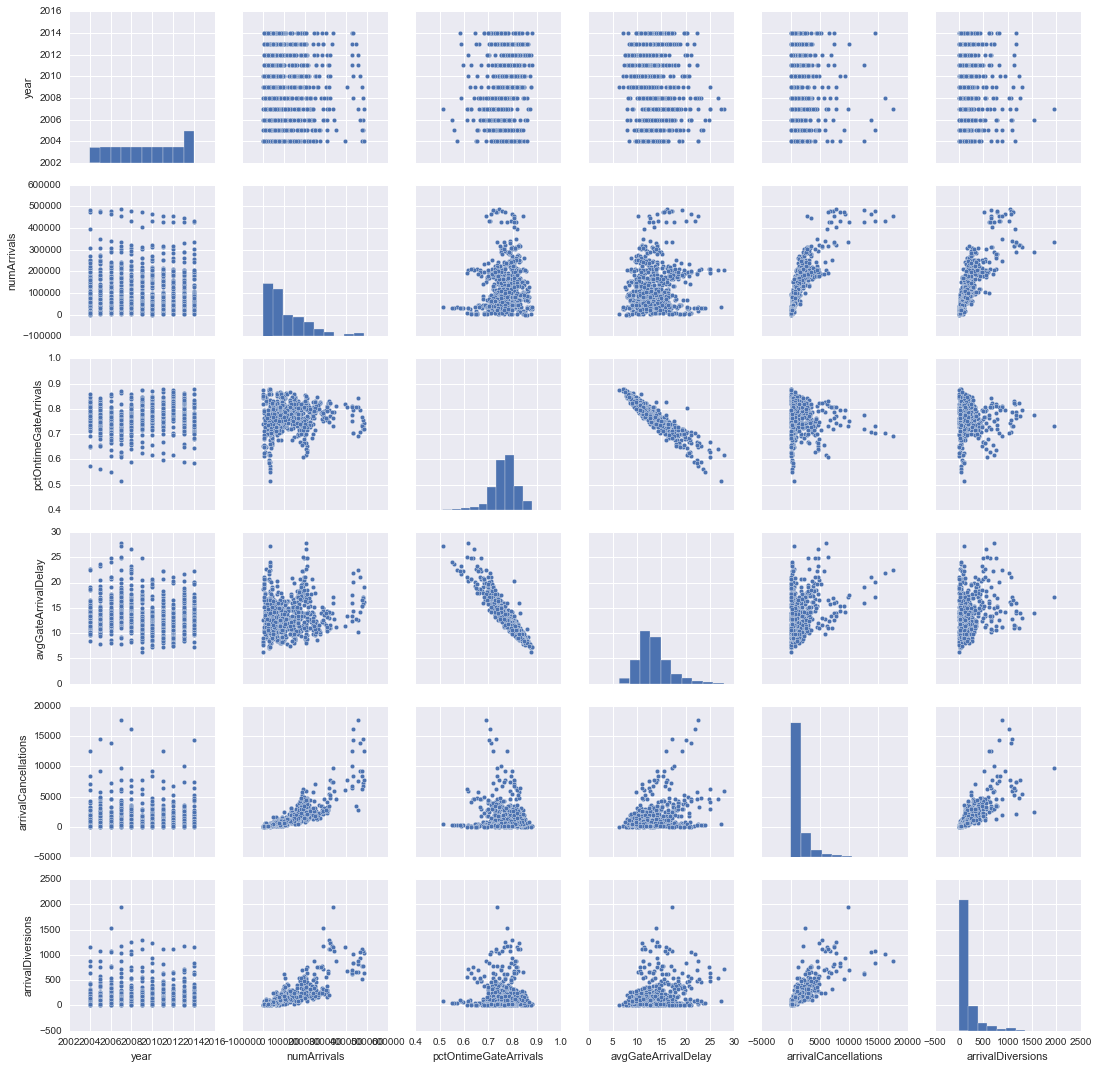

In [24]:
sns.pairplot(a_df)

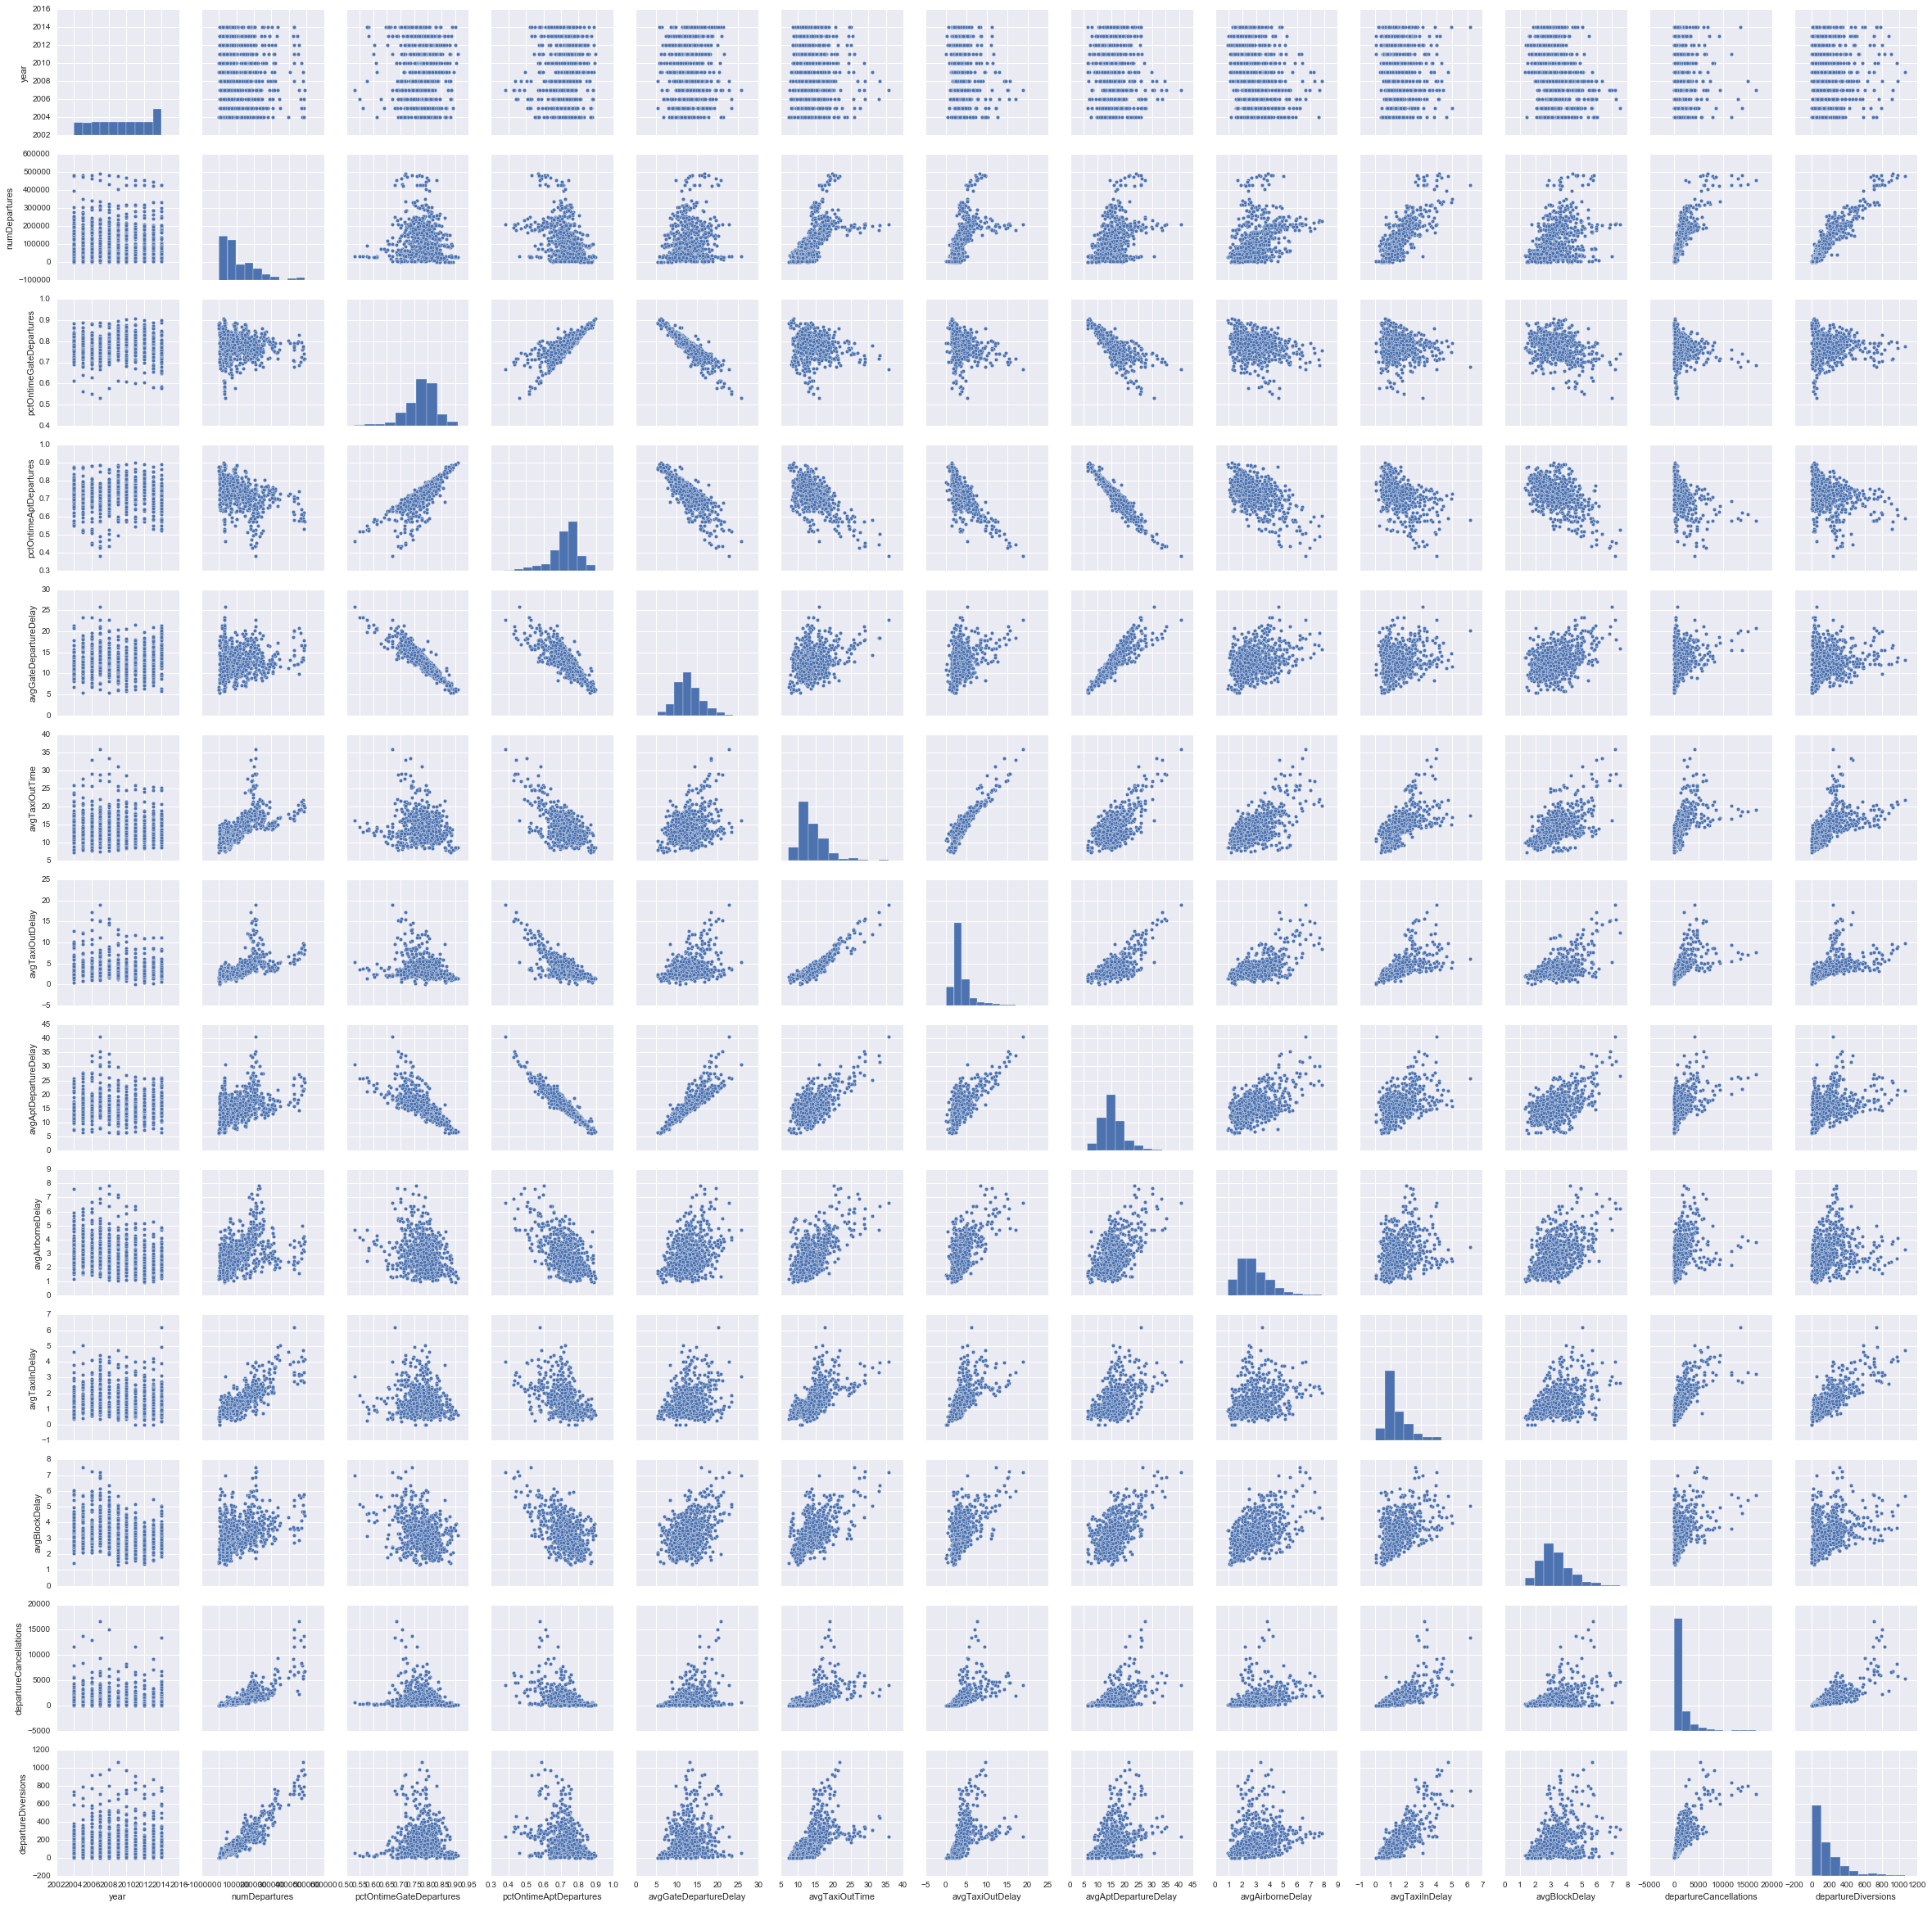

In [25]:
sns.pairplot(d_df)

In [26]:
cols_to_keep = [u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'latitude', u'longitude']

# Dummy-ing in a smart way the Genres (get_dummies does it too messy)
cv = CountVectorizer()
data = cv.fit_transform(df.county).todense()
columns = ['county_'+c for c in cv.get_feature_names()]
countydf = pd.DataFrame(data, columns=columns)

# countydf = df[['county']]
# countydf = pd.get_dummies(countydf)

statedf = df[['state']]
statedf = pd.get_dummies(statedf)

APtypedf = df[['APtype']]
APtypedf = pd.get_dummies(APtypedf)

FAAdf = df[['FAAregion']]
FAAdf = pd.get_dummies(FAAdf)

In [27]:
# Setting y here, can choose between FAAregion, airport, city, but cannot do county or state
# because we're dummifying those and adding them to X

y = LabelEncoder().fit_transform(df['airport'])
# y = df['airport']

In [339]:
x = df[cols_to_keep]

In [340]:
# Putting into numpy array form for the analysis
X = StandardScaler().fit_transform(x.astype(float))
X = pd.DataFrame(X, columns = cols_to_keep)
Xpca = X.copy()
# X = pd.concat([X, countydf, statedf, APtypedf, FAAdf], axis =1)

In [30]:
X.head(2)

year  numDepartures  numArrivals  pctOntimeGateDepartures  \
0 -1.593401      -0.607163    -0.606139                 0.457014   
1 -1.275754      -0.629020    -0.626018                 0.667555   

   pctOntimeAptDepartures  pctOntimeGateArrivals  avgGateDepartureDelay  \
0                0.709963               0.500021              -0.827217   
1                0.858688               0.658531              -1.084255   

   avgTaxiOutTime  avgTaxiOutDelay  avgAptDepartureDelay  avgAirborneDelay  \
0       -1.047069        -0.536544             -0.826210         -0.355457   
1       -1.073359        -0.596479             -1.032562         -0.526543   

   avgTaxiInDelay  avgBlockDelay  avgGateArrivalDelay  departureCancellations  \
0       -0.683889      -0.749327            -0.787421               -0.574713   
1       -0.613645      -0.961737            -0.981290               -0.586128   

   arrivalCancellations  departureDiversions  arrivalDiversions  latitude  \
0             -0.558841            -0.598447          -0.542560 -0.210788   
1             -0.581577            -0.656408          -0.599323 -0.210788   

   longitude  
0  -0.567524  
1  -0.567524

In [31]:
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    s_i = silhouette_score(X, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

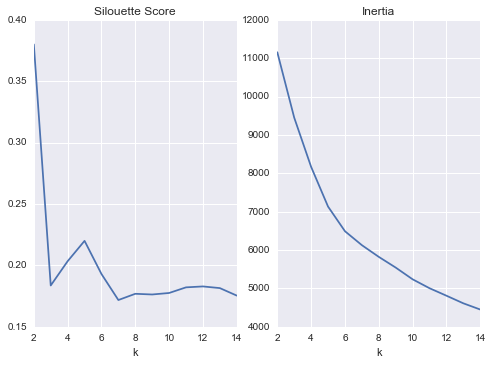

In [32]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [33]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [34]:
d_df['label']=labels
a_df['label'] = labels

/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
d_df.columns

Index([                u'airport',                    u'year',
                 u'numDepartures', u'pctOntimeGateDepartures',
        u'pctOntimeAptDepartures',   u'avgGateDepartureDelay',
                u'avgTaxiOutTime',         u'avgTaxiOutDelay',
          u'avgAptDepartureDelay',        u'avgAirborneDelay',
                u'avgTaxiInDelay',           u'avgBlockDelay',
        u'departureCancellations',     u'departureDiversions',
                         u'label'],
      dtype='object')

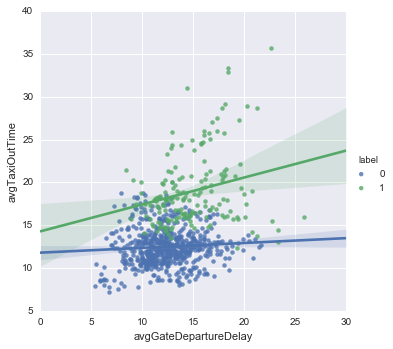

In [36]:
sns.lmplot('avgGateDepartureDelay', 'avgTaxiOutTime', data=d_df,  hue='label')

In [37]:
a_df.columns

Index([              u'airport',                  u'year',
                 u'numArrivals', u'pctOntimeGateArrivals',
         u'avgGateArrivalDelay',  u'arrivalCancellations',
           u'arrivalDiversions',                 u'label'],
      dtype='object')

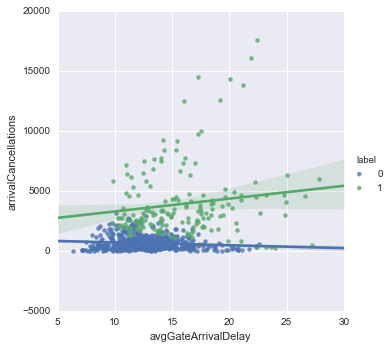

In [38]:
sns.lmplot('avgGateArrivalDelay', 'arrivalCancellations', data=a_df,  hue='label')

In [39]:
silhouette_score(X,labels,metric='euclidean')

0.38001019837843869

In [40]:
k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

In [41]:
# dies here a lot... death death death but only if you don't labelencode

labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

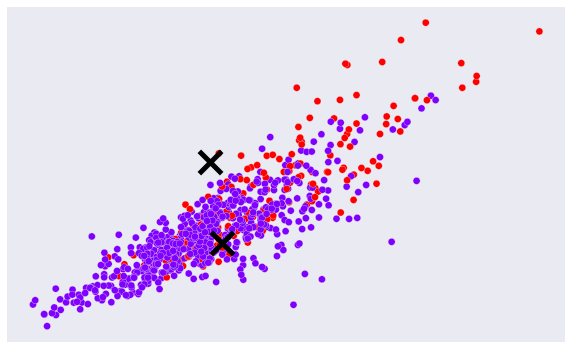

In [42]:
fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=labels, s=50, cmap='rainbow');
ax.set_xticks([]);
ax.set_yticks([]);

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=500, linewidths=5,
            color='k', zorder=10)

In [44]:
silhouette_score(X, labels)

0.38001019837843869

## Hierarchical clustering

In [45]:
Xh = X.as_matrix(columns=None)

In [46]:
Z = linkage(Xh, 'complete')

In [47]:
c, coph_dists = cophenet(Z, pdist(Xh))
c

0.76162111349590589

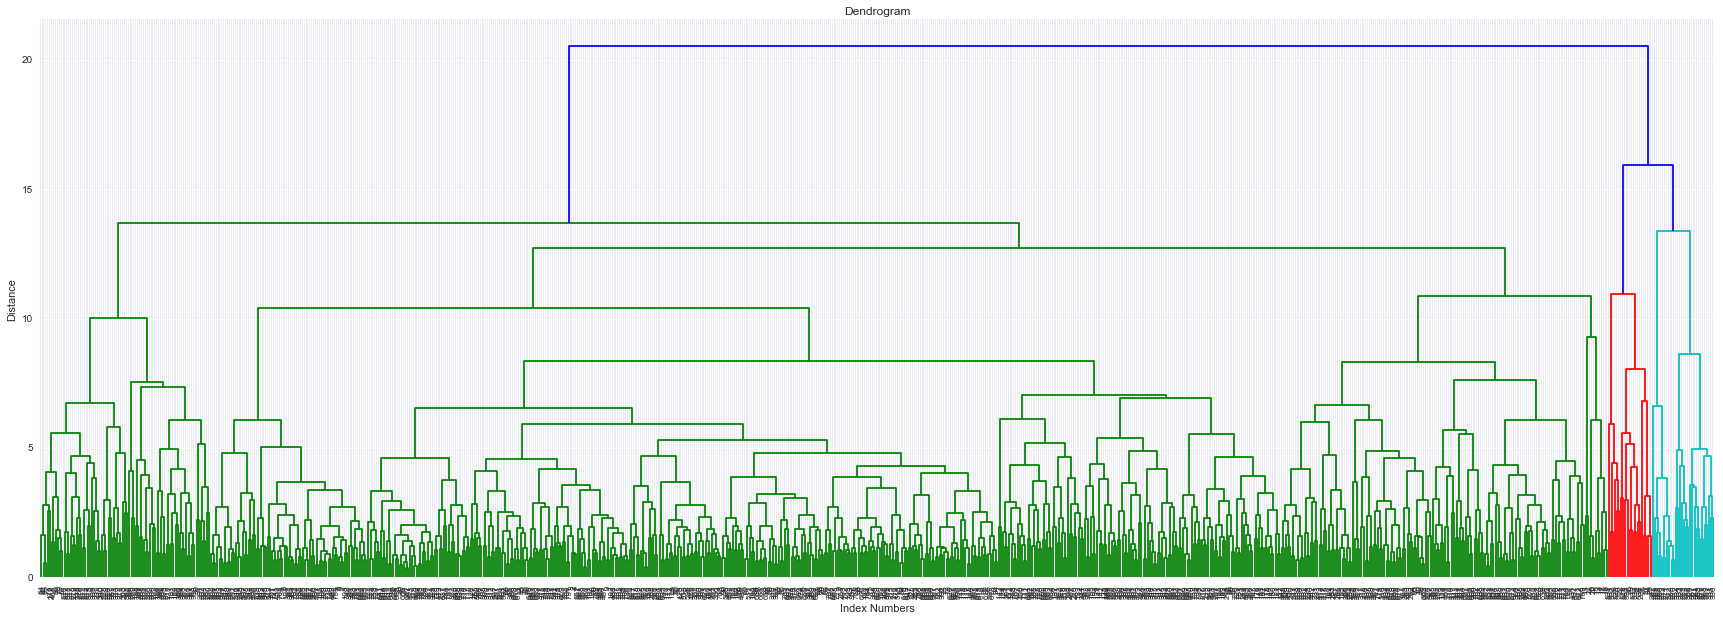

In [48]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

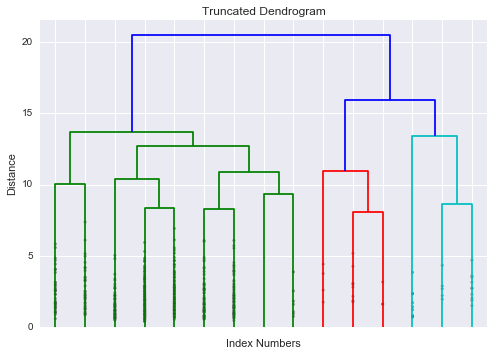

In [49]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [54]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [55]:
silhouette_score(X, clusters)

0.50158710423526698

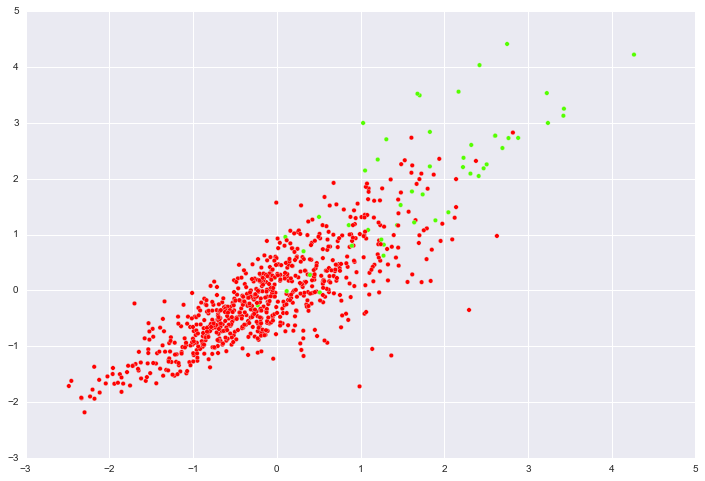

In [57]:
# clusters = hierarchy.fcluster(Z, max_dist, criterion='distance')

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=clusters, cmap='prism', s=20);

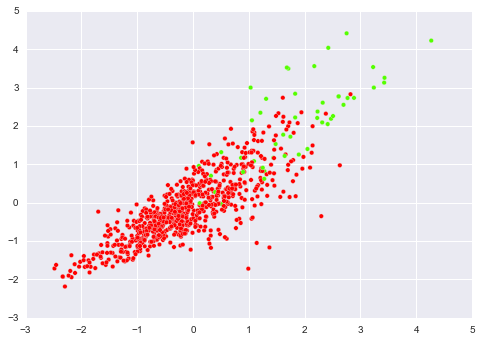

In [58]:
plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=clusters, cmap='prism')
plt.show()

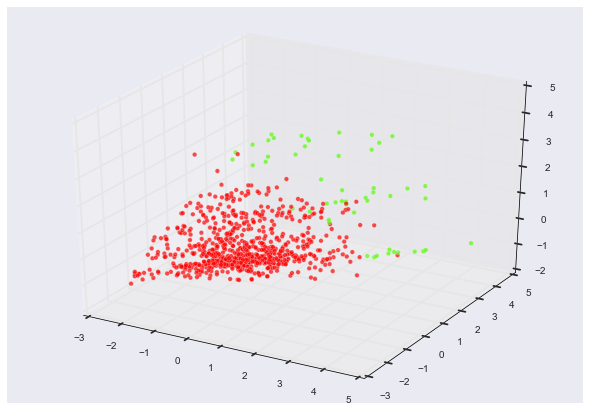

In [59]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'],X['numArrivals'], zdir='z',c=clusters,cmap='prism', alpha=.7, depthshade=True)
plt.show()

## PCA fun

In [65]:
Xpca1 = Xpca.copy()

In [111]:
Xpca = Xpca1.copy()

In [112]:
# Xpca['airport'] = LabelEncoder().fit_transform(df['airport'])
# Xpca['FAAregion'] = LabelEncoder().fit_transform(df['FAAregion'])
# Xpca['APtype'] = LabelEncoder().fit_transform(df['APtype'])
# Xpca['county'] = LabelEncoder().fit_transform(df['county'])
# Xpca['state'] = LabelEncoder().fit_transform(df['state'])

In [60]:
Xpca.head(1).T

0
year                    -1.593401
numDepartures           -0.607163
numArrivals             -0.606139
pctOntimeGateDepartures  0.457014
pctOntimeAptDepartures   0.709963
pctOntimeGateArrivals    0.500021
avgGateDepartureDelay   -0.827217
avgTaxiOutTime          -1.047069
avgTaxiOutDelay         -0.536544
avgAptDepartureDelay    -0.826210
avgAirborneDelay        -0.355457
avgTaxiInDelay          -0.683889
avgBlockDelay           -0.749327
avgGateArrivalDelay     -0.787421
departureCancellations  -0.574713
arrivalCancellations    -0.558841
departureDiversions     -0.598447
arrivalDiversions       -0.542560
latitude                -0.210788
longitude               -0.567524

In [61]:
Xpca = (Xpca - Xpca.mean())/Xpca.std()

In [62]:
Xpca_corr = np.corrcoef(Xpca.values.T)

In [63]:
eig_vals, eig_vecs = np.linalg.eig(Xpca_corr)

In [64]:
tot=sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 46.78224876  68.43707195  75.84422331  81.38254894  85.96982638
  89.66555824  92.33277365  94.26809013  95.82502002  97.02726188
  97.91816587  98.73994575  99.34477723  99.6437941   99.89836232
  99.96653075  99.98653184  99.99444408  99.99915691 100.        ]


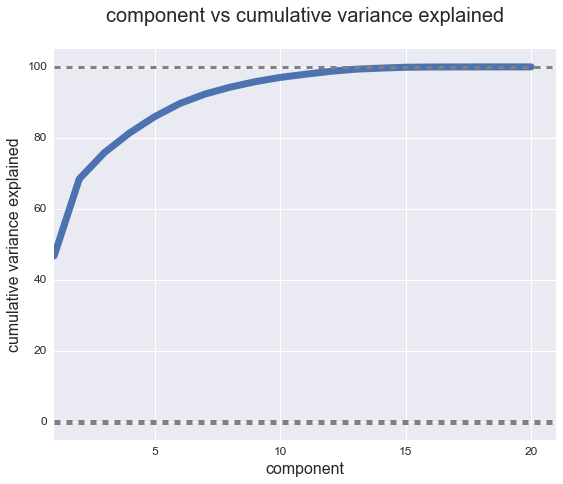

In [65]:
plt.figure(figsize=(9,7))

component_number = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(component_number, cum_var_exp, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1,21])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [66]:
PCA_set = PCA(n_components=3)
XPCA = PCA_set.fit_transform(Xpca)

In [67]:
PCdf = pd.DataFrame(XPCA, columns=['PC1','PC2','PC3'])

In [68]:
PCdf.head()

PC1       PC2       PC3
0  2.658765 -0.356247  0.999987
1  3.058550 -0.700638  0.814898
2  2.451006 -0.112166  0.366767
3  2.022363  0.062444  0.308438
4  2.606836 -0.326953  0.091743

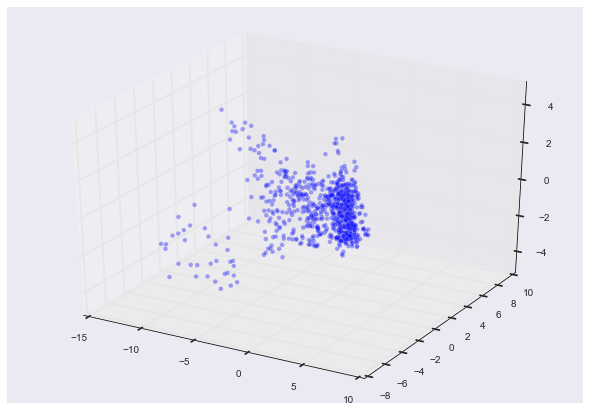

In [133]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'], PCdf['PC3'], zdir='z',alpha=.35, depthshade=True, )
plt.show()

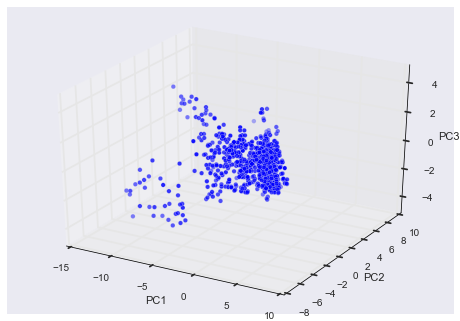

In [130]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(PCdf['PC1'], PCdf['PC2'],PCdf['PC3'])
threedee.set_xlabel('PC1')
threedee.set_ylabel('PC2')
threedee.set_zlabel('PC3')
plt.show()


In [92]:
airports2 = df[['airport', 'year']]

In [94]:
airport_pca = airports2.join(PCdf, on=None, how='left')

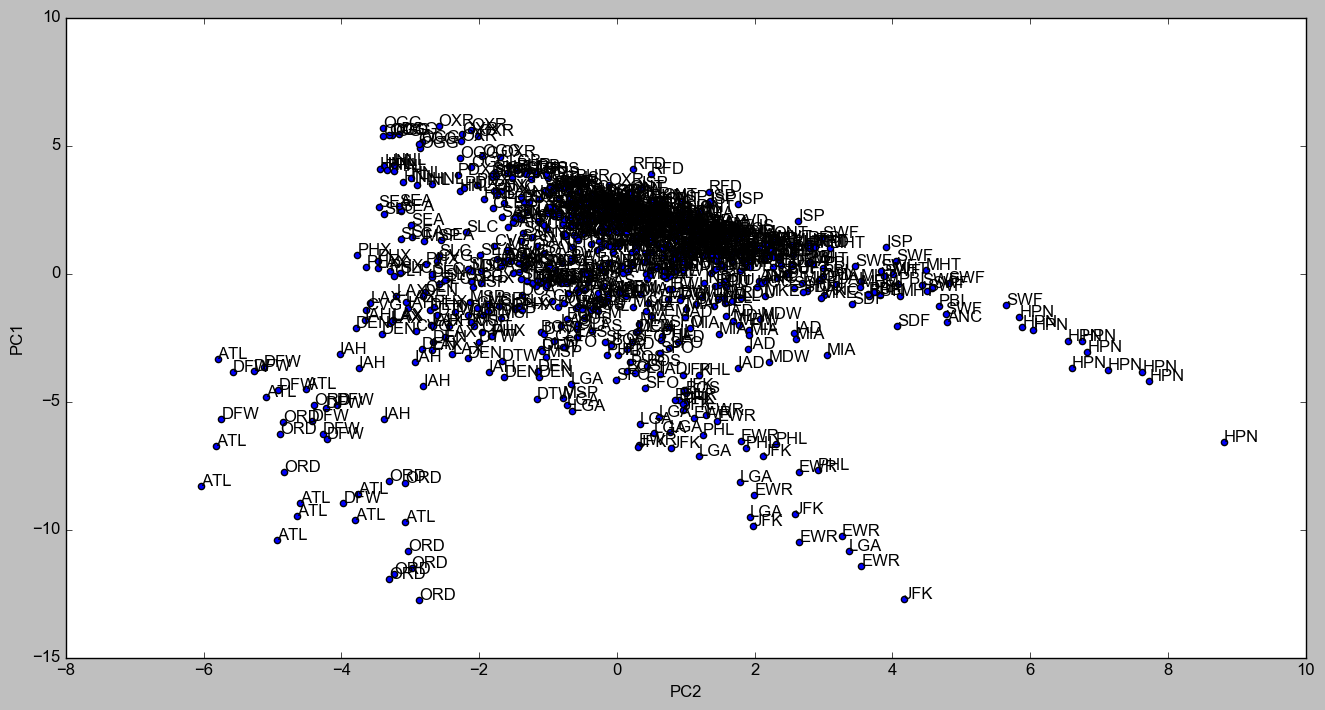

In [176]:
matplotlib.style.use('classic')

graph = airport_pca.plot(kind='scatter', x ='PC2', y = 'PC1',figsize=(16,8))

for i, airport in enumerate(df['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

In [162]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(Xpca)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [165]:
silhouette_score(Xpca, labels, metric='euclidean')

0.38001019837843891

In [166]:
airport_pca['cluster'] = pd.Series(clusters.labels_)

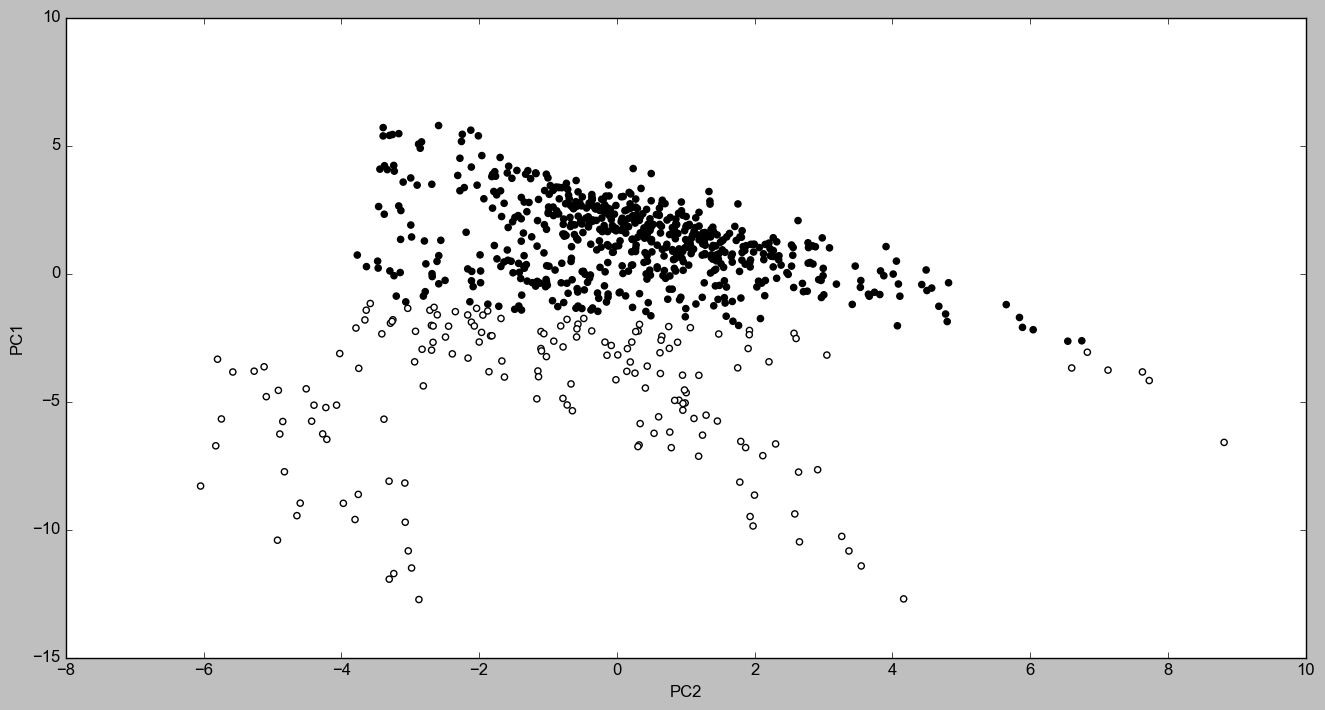

In [171]:
matplotlib.style.use('classic')

graph = airport_pca.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=airport_pca.cluster.astype(np.float), 
    figsize=(16,8))

In [201]:
X_pcs = X.copy()

X_pcs = (X - X.mean()) / X.std()

X_pcs['PC1'] = PCdf['PC1']
X_pcs['PC2'] = PCdf['PC2']
X_pcs['PC3'] = PCdf['PC3']

In [202]:
X_pcs = pd.melt(X_pcs, id_vars=['PC1','PC2','PC3'])

In [203]:
len(X_pcs)

15980

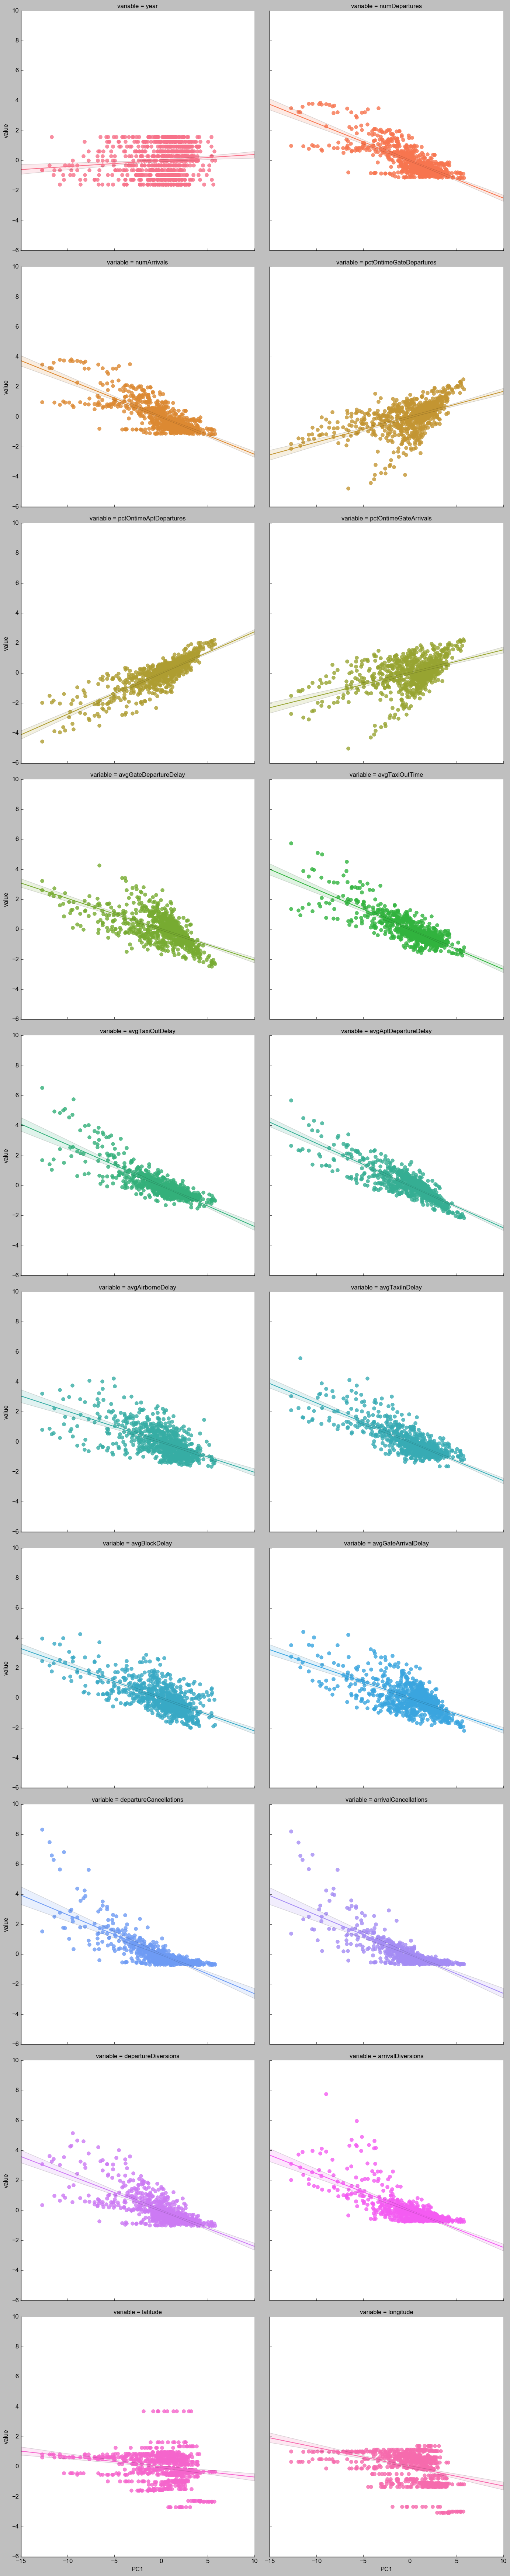

In [204]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

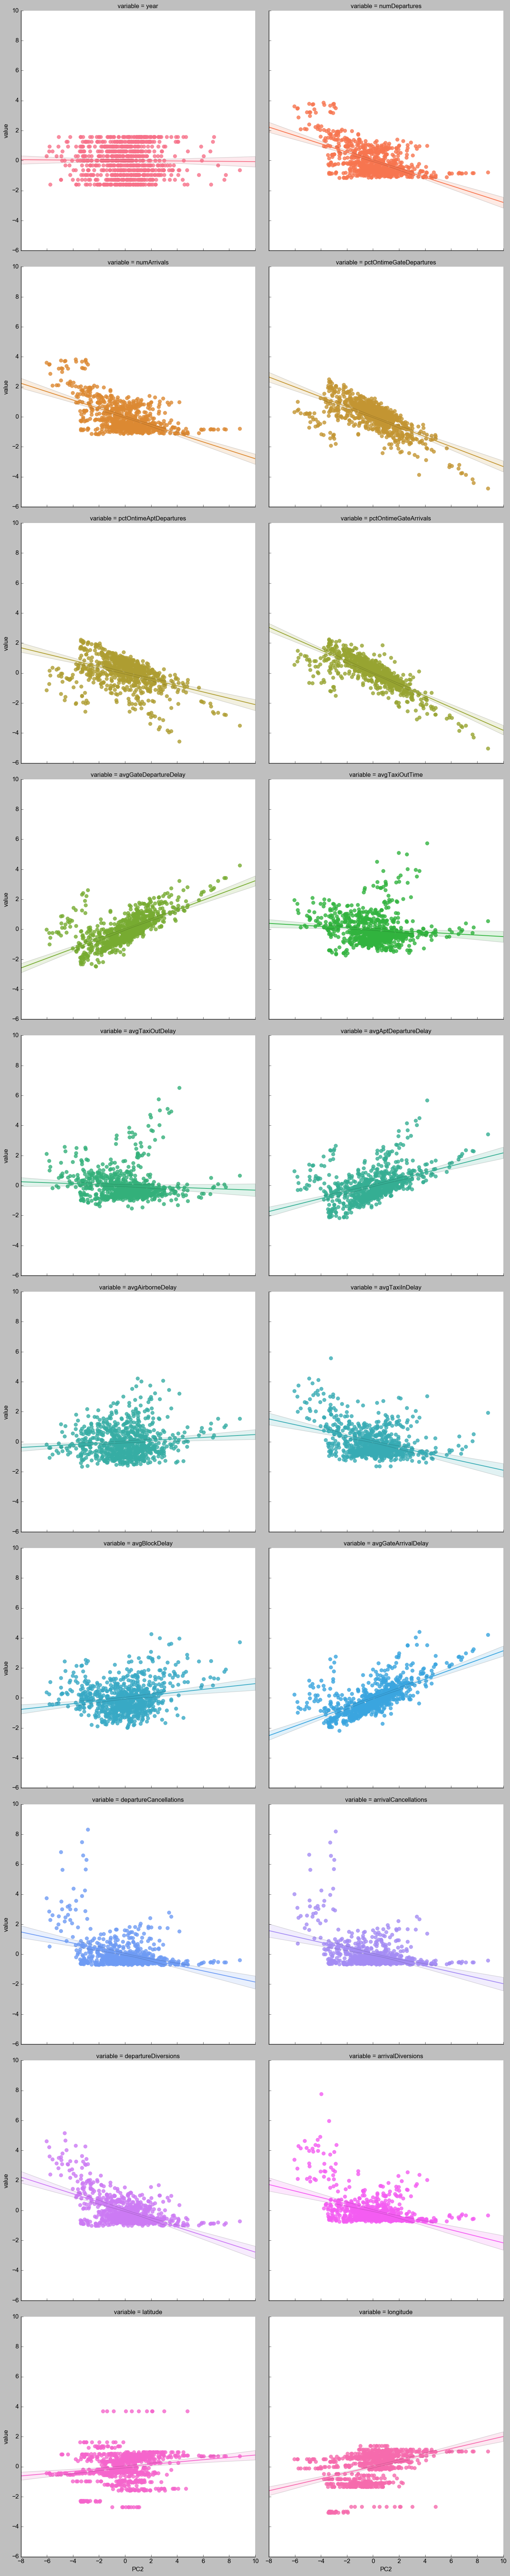

In [200]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

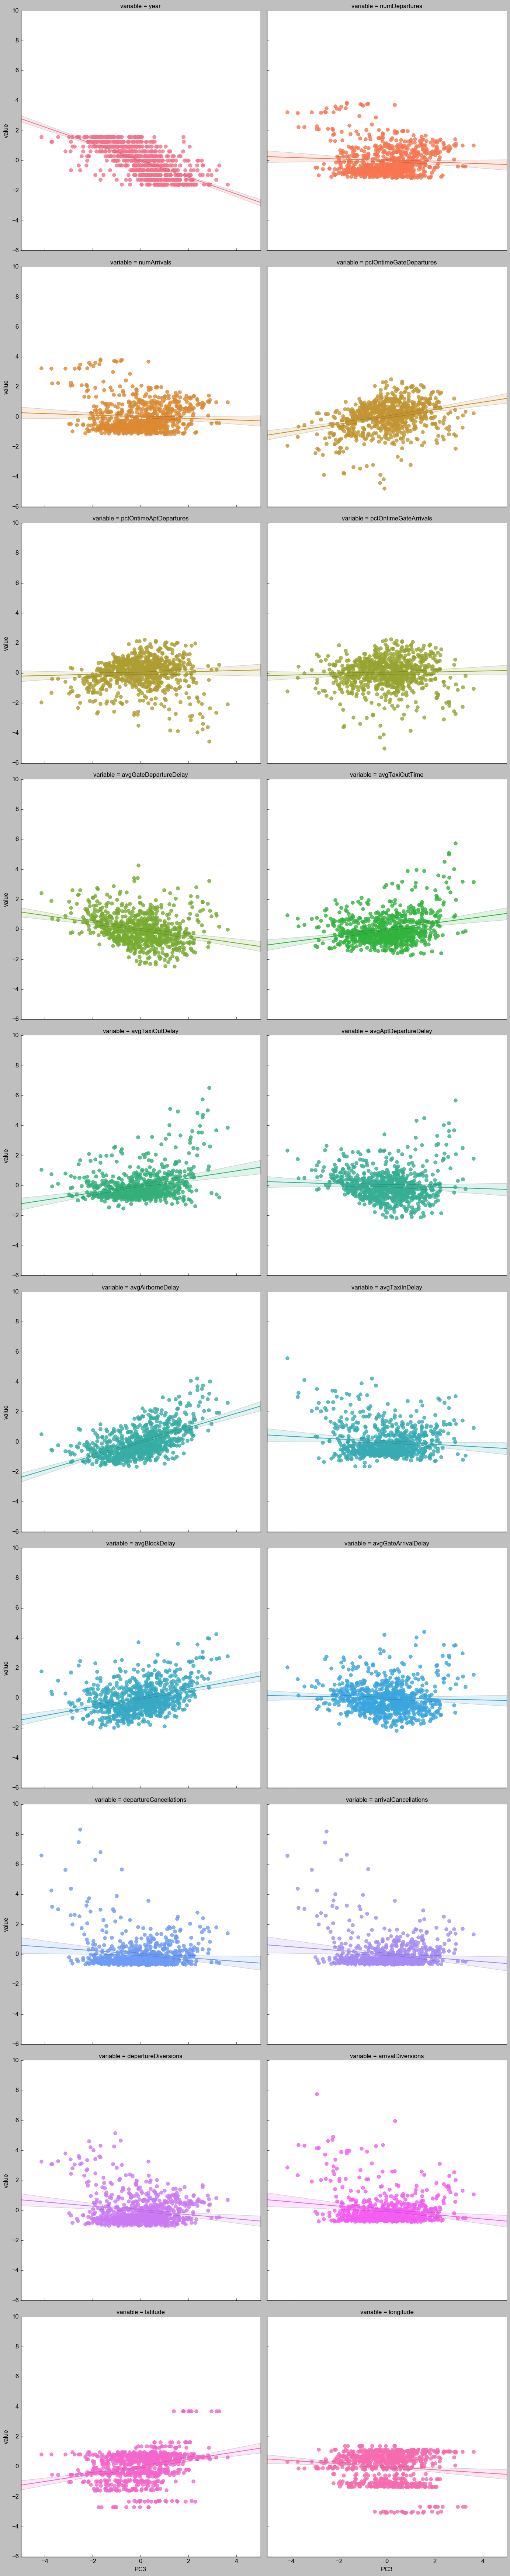

In [205]:
pc3 = sns.lmplot(x="PC3", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

## Re-running the clustering analyses

In [82]:
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(PCdf)
    labels = kmeans.labels_
    s_i = silhouette_score(PCdf, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

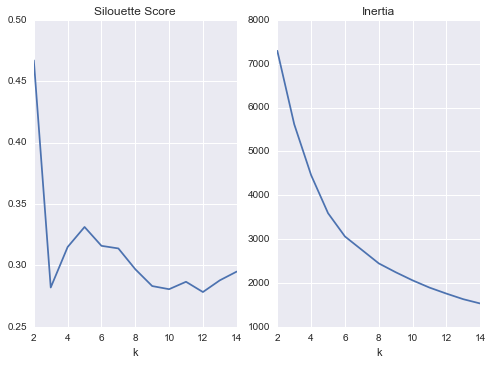

In [83]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [84]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(PCdf)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [88]:
PCdf['label']=labels


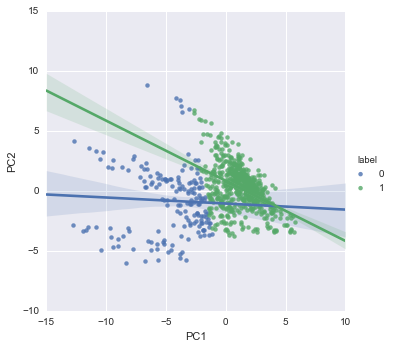

In [135]:
sns.lmplot('PC1', 'PC2', data=PCdf,  hue='label')

In [138]:
silhouette_score(PCdf,labels)

0.47438449579453362

## Hierarchical clustering with PCA

In [139]:
Xhpca =PCdf.as_matrix(columns=None)

In [140]:
Z = linkage(Xhpca, 'complete')

In [143]:
c, coph_dists = cophenet(Z, pdist(Xhpca))
c

0.72383570544925113

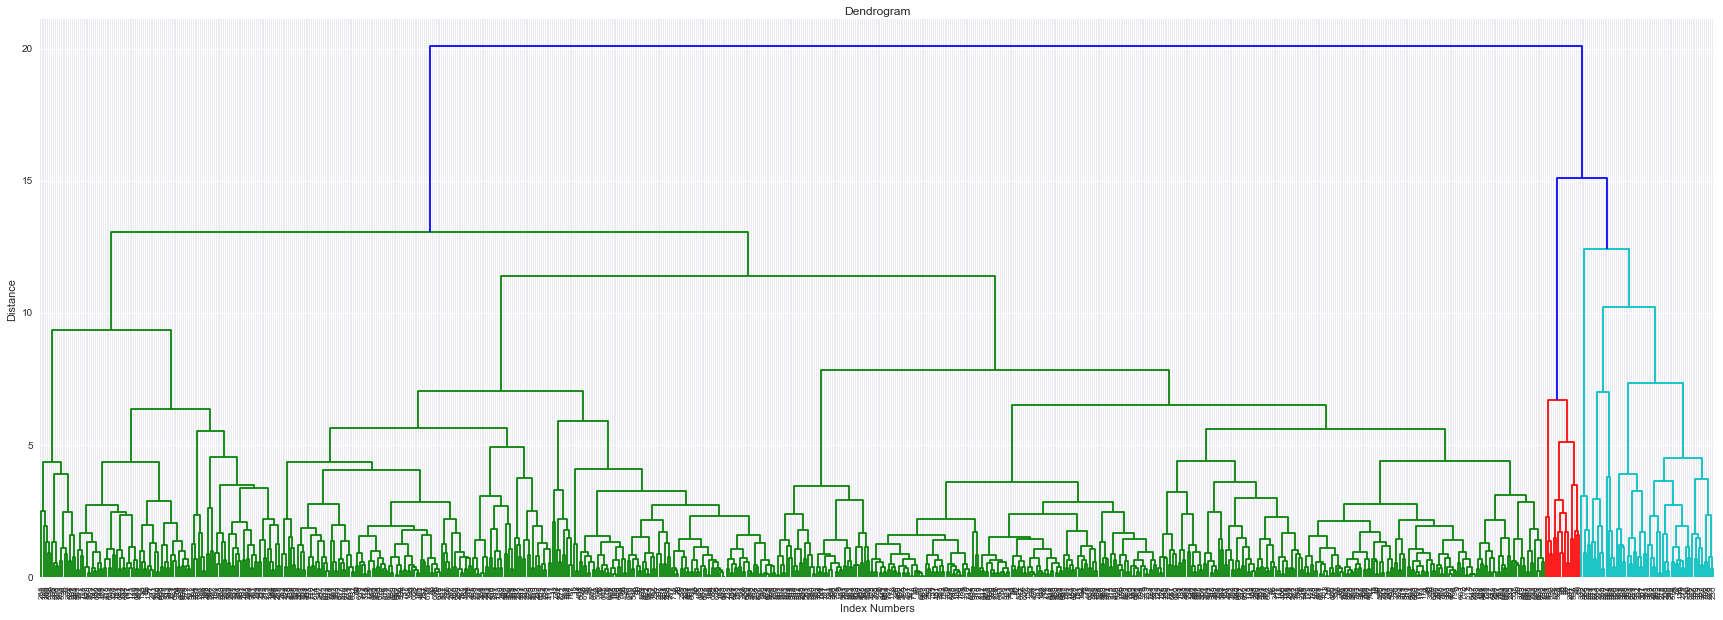

In [144]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

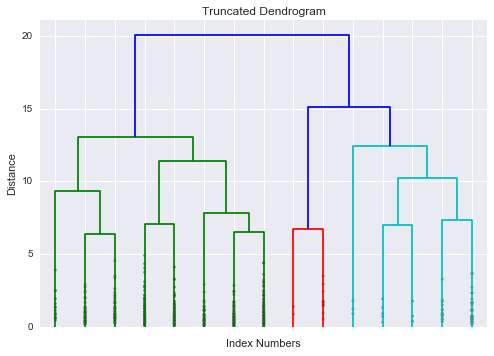

In [145]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [146]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [148]:
silhouette_score(PCdf, clusters)

0.52024455721082974

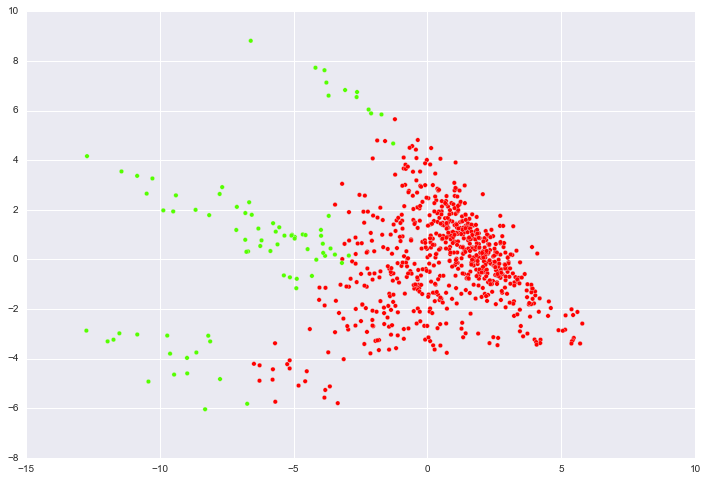

In [156]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC2'], c=clusters, cmap='prism', s=20);

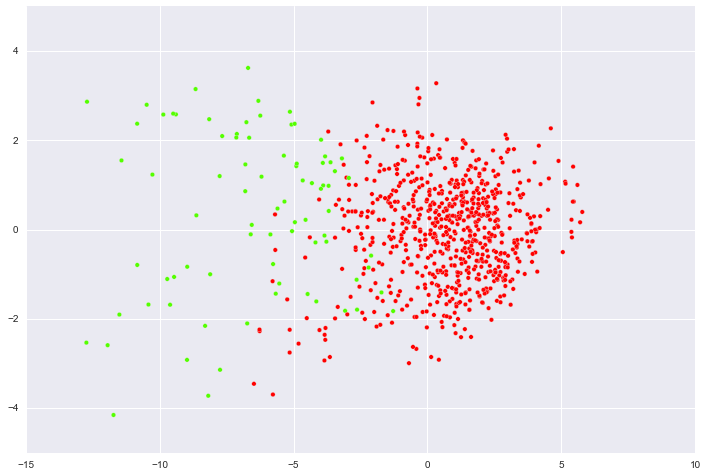

In [157]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC3'], c=clusters, cmap='prism', s=20);

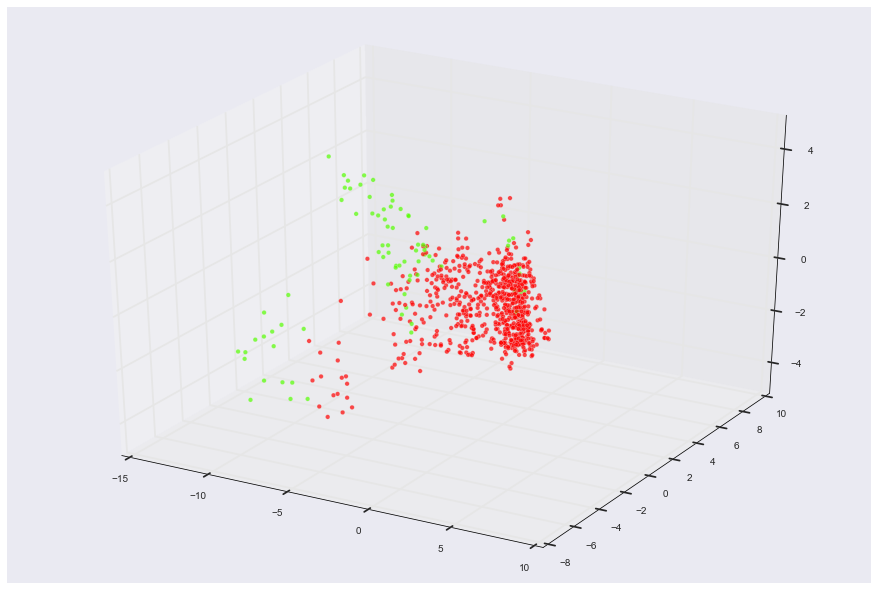

In [160]:
fig = pylab.figure(figsize=(12,8))
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'],PCdf['PC3'], zdir='z',c=clusters,cmap='prism', alpha=.7, depthshade=True)
plt.show()

## Logistic Regression

In [341]:

LRdf = pd.concat([X,PCdf],axis=1)
LRdf.drop('label',1,inplace=True)
LRdf.drop('latitude',1,inplace=True)
LRdf.drop('longitude',1,inplace=True)
X = LRdf
y = LabelEncoder().fit_transform(df['FAAregion'])

In [305]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


In [306]:
X_train, X_test, y_train, y_test = train_test_split(LRdf.values,y,test_size = 0.33,  random_state = 77)

In [307]:
logreg = LogisticRegression(random_state = 77)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [308]:
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat)
confusion

0  1   2   3  4  5   6   7   8
0  4  0   0   0  0  2   0   0   0
1  0  1   2   4  1  0   2   0   2
2  0  0  34   4  0  0   2   2   0
3  0  0   6  13  0  4   6   2   0
4  0  0  10   0  2  0   2   0   0
5  0  0   0   0  0  9   0   0   3
6  0  0   3   2  0  1  52   0   0
7  0  0   0   0  0  0   1  15  10
8  0  0   0   0  0  0   2   0  61

In [309]:
# create a function that plot the confusion matrix 
import matplotlib.patheffects as path_effects
# function that plots confusion matrix

def plot_confusion_matrix(cm, title='Confusion matrix', labels= [1,2,3], cmap=plt.cm.Blues, t_number =2):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(t_number)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

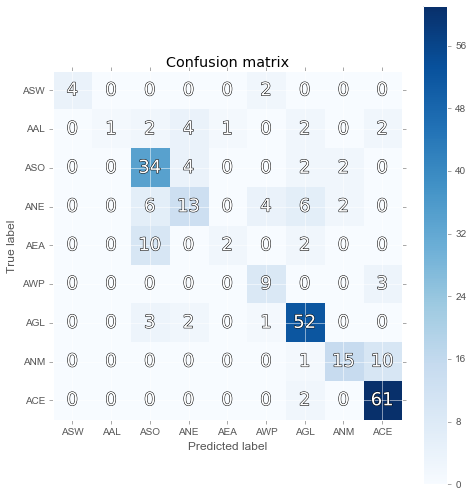

In [310]:
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [311]:
logreg.score(X_test,y_test)

0.72348484848484851

In [312]:
# Accuracy tells us the percent of houses selling for over and under 200k correctly predicted
print(accuracy_score(y_test, y_pred))

# Precision tells us how well the classifier avoided misclassifying the over 200k houses
print(precision_score(y_test, y_pred))

# Recall tells us how well the classifier correctly identified houses as selling for over 200k
print(recall_score(y_test, y_pred))

0.723484848485
0.733620225241
0.723484848485


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [313]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

In [314]:
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat)
confusion

0  1   2   3  4  5   6   7   8
0  2  0   2   0  0  0   0   0   2
1  0  4   1   1  1  0   3   0   2
2  0  1  32   3  2  1   3   0   0
3  0  0   5  13  1  1   9   1   1
4  0  0   3   1  7  0   2   0   1
5  0  0   0   0  0  8   2   0   2
6  0  1   8   4  0  4  39   0   2
7  0  0   0   0  0  0   0  24   2
8  0  2   0   2  0  2   3   3  51

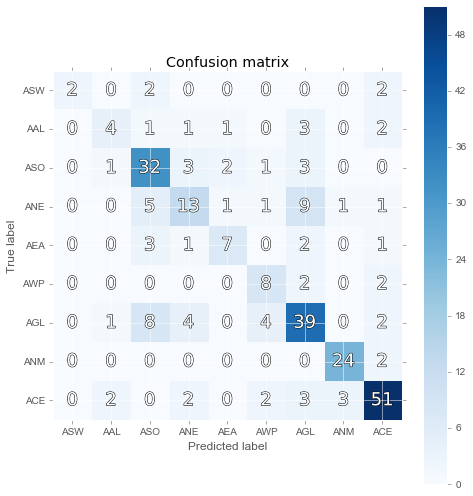

In [315]:
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [316]:
ranfor.score(X_test,y_test)

0.68181818181818177

In [317]:
# Accuracy tells us the percent of houses selling for over and under 200k correctly predicted
print(accuracy_score(y_test, y_pred))

# Precision tells us how well the classifier avoided misclassifying the over 200k houses
print(precision_score(y_test, y_pred))

# Recall tells us how well the classifier correctly identified houses as selling for over 200k
print(recall_score(y_test, y_pred))

0.681818181818
0.683414319133
0.681818181818


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [318]:
ranfor.feature_importances_

array([ 0.01457412,  0.04702103,  0.06306266,  0.0214363 ,  0.04302888,
        0.04379319,  0.04614314,  0.09202939,  0.03549355,  0.04338664,
        0.06485651,  0.03789858,  0.04023231,  0.05379801,  0.04001353,
        0.0343265 ,  0.07593472,  0.05181596,  0.04863548,  0.05862593,
        0.04389357])

In [319]:
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgTaxiOutTime              0.092029
departureDiversions         0.075935
avgAirborneDelay            0.064857
numArrivals                 0.063063
PC2                         0.058626
avgGateArrivalDelay         0.053798
arrivalDiversions           0.051816
PC1                         0.048635
numDepartures               0.047021
avgGateDepartureDelay       0.046143

In [342]:
X.columns

Index([                   u'year',           u'numDepartures',
                   u'numArrivals', u'pctOntimeGateDepartures',
        u'pctOntimeAptDepartures',   u'pctOntimeGateArrivals',
         u'avgGateDepartureDelay',          u'avgTaxiOutTime',
               u'avgTaxiOutDelay',    u'avgAptDepartureDelay',
              u'avgAirborneDelay',          u'avgTaxiInDelay',
                 u'avgBlockDelay',     u'avgGateArrivalDelay',
        u'departureCancellations',    u'arrivalCancellations',
           u'departureDiversions',       u'arrivalDiversions',
                           u'PC1',                     u'PC2',
                           u'PC3'],
      dtype='object')

In [343]:
X.head().T

0         1         2         3         4
year                    -1.593401 -1.275754 -0.958108 -0.640461 -0.322815
numDepartures           -0.607163 -0.629020 -0.650929 -0.614469 -0.651878
numArrivals             -0.606139 -0.626018 -0.632961 -0.608259 -0.650238
pctOntimeGateDepartures  0.457014  0.667555  0.367055  0.409163  0.596737
pctOntimeAptDepartures   0.709963  0.858688  0.640207  0.571768  0.756029
pctOntimeGateArrivals    0.500021  0.658531  0.153280 -0.042876  0.408878
avgGateDepartureDelay   -0.827217 -1.084255 -0.675630 -0.527339 -0.692107
avgTaxiOutTime          -1.047069 -1.073359 -1.047069 -0.928768 -0.910365
avgTaxiOutDelay         -0.536544 -0.596479 -0.652133 -0.549387 -0.545106
avgAptDepartureDelay    -0.826210 -1.032562 -0.773476 -0.631323 -0.775769
avgAirborneDelay        -0.355457 -0.526543 -0.646303 -0.586423 -0.902931
avgTaxiInDelay          -0.683889 -0.613645 -0.672181 -0.145352 -0.449742
avgBlockDelay           -0.749327 -0.961737 -0.638065 -0.233475 -0.506573
avgGateArrivalDelay     -0.787421 -0.981290 -0.495078 -0.221199 -0.599706
departureCancellations  -0.574713 -0.586128 -0.493179 -0.507312 -0.525249
arrivalCancellations    -0.558841 -0.581577 -0.511347 -0.523979 -0.526000
departureDiversions     -0.598447 -0.656408 -0.598447 -0.389788 -0.552079
arrivalDiversions       -0.542560 -0.599323 -0.201977 -0.546926 -0.560025
PC1                      2.658765  3.058550  2.451006  2.022363  2.606836
PC2                     -0.356247 -0.700638 -0.112166  0.062444 -0.326953
PC3                      0.999987  0.814898  0.366767  0.308438  0.091743

In [344]:
y = X['avgAptDepartureDelay'].apply(lambda x: 1 if x > np.median(X['avgAptDepartureDelay']) else 0)

In [357]:
X.drop(['avgAptDepartureDelay'],1, inplace=True)
X.drop(['pctOntimeAptDepartures'],1, inplace=True)

In [358]:
X.columns

Index([                   u'year',           u'numDepartures',
                   u'numArrivals', u'pctOntimeGateDepartures',
         u'pctOntimeGateArrivals',   u'avgGateDepartureDelay',
                u'avgTaxiOutTime',         u'avgTaxiOutDelay',
              u'avgAirborneDelay',          u'avgTaxiInDelay',
                 u'avgBlockDelay',     u'avgGateArrivalDelay',
        u'departureCancellations',    u'arrivalCancellations',
           u'departureDiversions',       u'arrivalDiversions',
                           u'PC1',                     u'PC2',
                           u'PC3'],
      dtype='object')

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 77, stratify = y)

In [360]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

In [361]:
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat)

             precision    recall  f1-score   support

          0       0.93      0.91      0.92       120
          1       0.91      0.93      0.92       120

avg / total       0.92      0.92      0.92       240



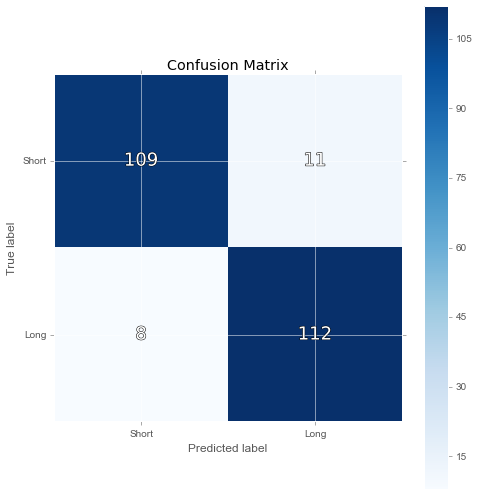

In [362]:
print classification_report(y_test,y_pred)
plot_confusion_matrix(conmat, labels = ['Short','Long'], title = 'Confusion Matrix')

In [363]:
ranfor.score(X_test, y_test)

0.92083333333333328

In [364]:
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgGateDepartureDelay         0.245916
PC1                           0.179300
pctOntimeGateDepartures       0.154265
PC2                           0.083022
avgTaxiOutDelay               0.055516
avgGateArrivalDelay           0.053531
pctOntimeGateArrivals         0.044190
arrivalDiversions             0.037481
avgTaxiOutTime                0.020480
numArrivals                   0.019293

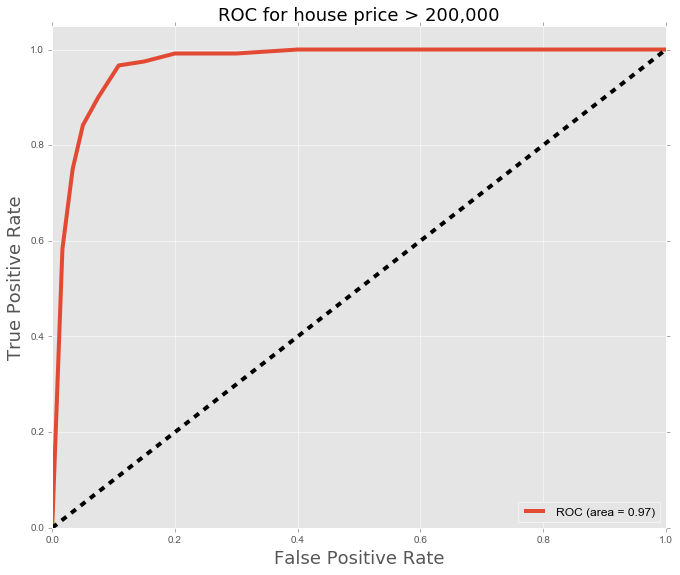

In [366]:
y_score = ranfor.predict_proba(X_test).T[1]
plot_roc(y_test, y_score)

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

#### 3.2 Format and Clean the Data

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

#### 4.2 Find correlations in the data

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied